In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [42]:
df1 = pd.read_csv("weatherstats_moncton_hourly.csv")
df1.columns

C:\Users\bnaga\AppData\Local\Temp\ipykernel_19472\661136916.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("weatherstats_moncton_hourly.csv")


Index(['date_time_local', 'unixtime', 'pressure_station', 'pressure_sea',
       'wind_dir', 'wind_dir_10s', 'wind_speed', 'wind_gust',
       'relative_humidity', 'dew_point', 'temperature', 'windchill', 'humidex',
       'visibility', 'health_index', 'cloud_cover_4', 'cloud_cover_8',
       'cloud_cover_10', 'solar_radiation', 'max_air_temp_pst1hr',
       'min_air_temp_pst1hr'],
      dtype='object')

In [43]:
# df = pd.read_csv("weatherstats_moncton_hourly.csv")
# df.columns

In [44]:
df = df1[['date_time_local','temperature', 'wind_speed']]

In [45]:
df.isna().sum()
df = df.dropna() 

In [46]:
df.date_time_local = df.date_time_local.apply(lambda x: x[:-3])


In [47]:
df.date_time_local = pd.to_datetime(df.date_time_local)


<Axes: ylabel='Frequency'>

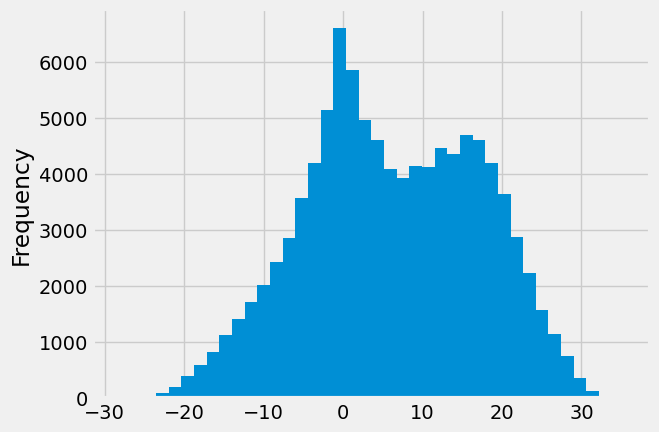

In [48]:
df['temperature'].plot(kind='hist', bins = 40)

<Axes: xlabel='date_time_local', ylabel='temperature'>

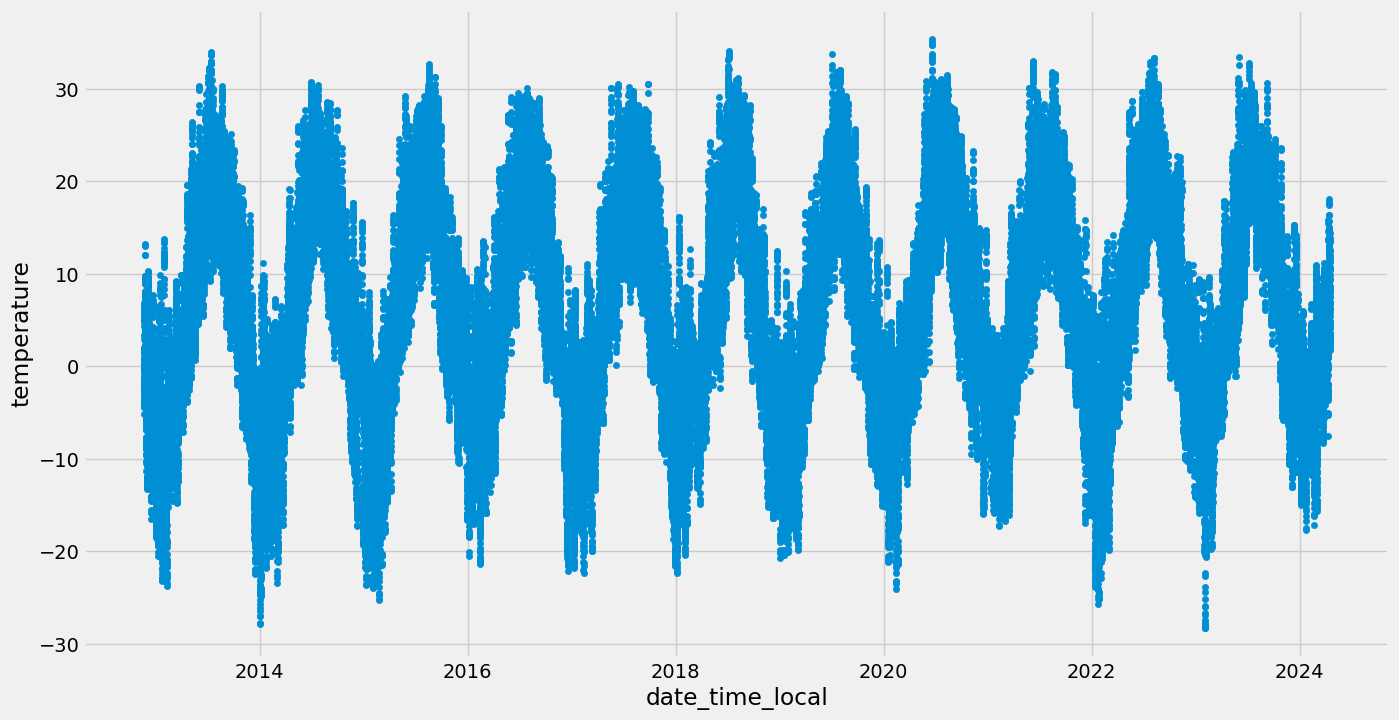

In [49]:
df.plot(kind='scatter', x = 'date_time_local', y = 'temperature' , figsize = (15, 8) )

In [50]:
df = df.set_index('date_time_local')
df.head()


,temperature,wind_speed
date_time_local,,
2024-04-17 11:00:00,4.1,22.0
2024-04-17 10:00:00,3.3,21.0
2024-04-17 09:00:00,3.0,21.0
2024-04-17 08:00:00,3.1,20.0
2024-04-17 07:00:00,3.0,17.0


In [51]:
df.head()

,temperature,wind_speed
date_time_local,,
2024-04-17 11:00:00,4.1,22.0
2024-04-17 10:00:00,3.3,21.0
2024-04-17 09:00:00,3.0,21.0
2024-04-17 08:00:00,3.1,20.0
2024-04-17 07:00:00,3.0,17.0


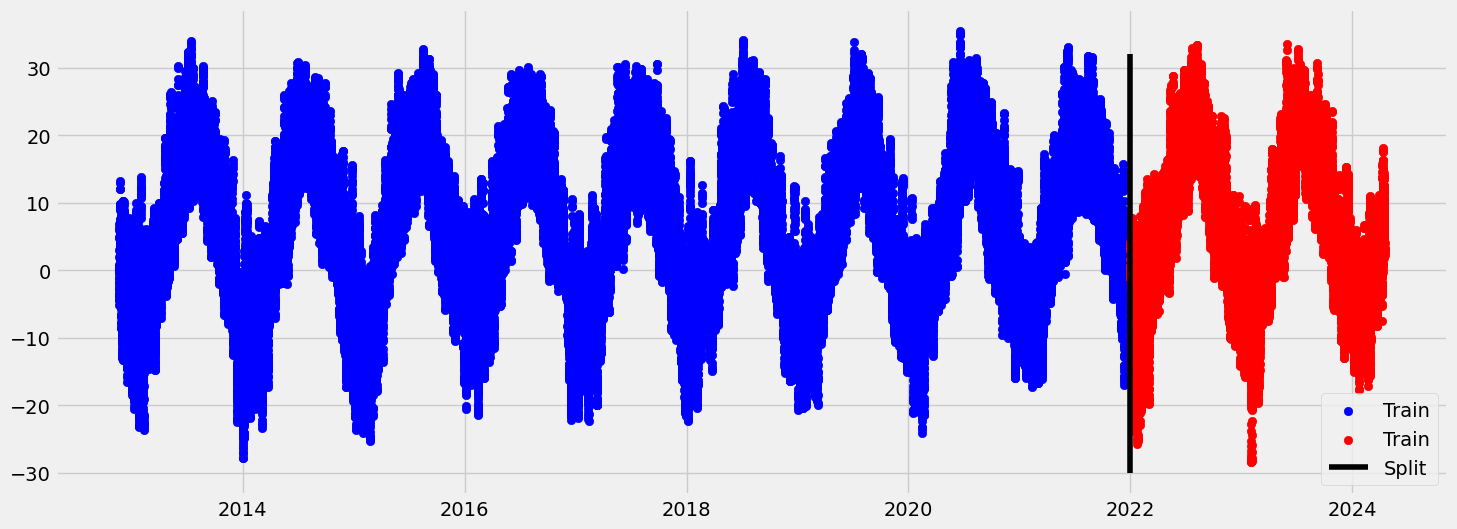

In [52]:
train = df.loc[df.index < '01-01-2022']
test = df.loc[df.index >= '01-01-2022']



plt.figure(figsize=(16,6)) 
plt.scatter(train.index, train.temperature, color = 'blue', label = 'Train') 
plt.scatter(test.index, test.temperature, color = 'red', label = 'Train') 
plt.vlines(x = pd.Timestamp('2022-01-01'),  ymin=-30, ymax=32, colors='k', linestyles='solid', label='Split')
plt.legend()

            

In [53]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [54]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'quarter', 'month']
TARGET = 'temperature'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [55]:
X_train

,dayofyear,hour,quarter,month
date_time_local,,,,
2021-12-31 23:00:00,365,23,4,12
2021-12-31 22:00:00,365,22,4,12
2021-12-31 21:00:00,365,21,4,12
2021-12-31 20:00:00,365,20,4,12
2021-12-31 19:00:00,365,19,4,12
...,...,...,...,...
2012-11-19 23:00:00,324,23,4,11
2012-11-19 22:00:00,324,22,4,11
2012-11-19 21:00:00,324,21,4,11


In [56]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# y_train = scaler.fit_transform(y_train)
# X_train = pd.DataFrame(X_train, columns=['dayofyear', 'hour', 'quarter', 'month'])
# y_train = pd.DataFrame(y_train, columns=['dayofyear', 'hour', 'quarter', 'month'])


In [57]:
X_train

,dayofyear,hour,quarter,month
date_time_local,,,,
2021-12-31 23:00:00,365,23,4,12
2021-12-31 22:00:00,365,22,4,12
2021-12-31 21:00:00,365,21,4,12
2021-12-31 20:00:00,365,20,4,12
2021-12-31 19:00:00,365,19,4,12
...,...,...,...,...
2012-11-19 23:00:00,324,23,4,11
2012-11-19 22:00:00,324,22,4,11
2012-11-19 21:00:00,324,21,4,11


In [62]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       #early_stopping_rounds=50,
                       objective='reg:linear',
                       gamma= 10000,
                       max_depth=100,
                       max_leaves=None,
                       learning_rate=0.1, 
                       n_jobs = -1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[22:24:55] WARNING: c:\b\abs_7diruzi3as\croot\xgboost-split_1712794727514\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11.42630	validation_1-rmse:11.06676
[100]	validation_0-rmse:5.00899	validation_1-rmse:4.97400
[200]	validation_0-rmse:5.00899	validation_1-rmse:4.97397
[300]	validation_0-rmse:5.00899	validation_1-rmse:4.97397
[400]	validation_0-rmse:5.00899	validation_1-rmse:4.97397
[500]	validation_0-rmse:5.00899	validation_1-rmse:4.97397
[600]	validation_0-rmse:5.00899	validation_1-rmse:4.97397
[700]	validation_0-rmse:5.00899	validation_1-rmse:4.97397
[800]	validation_0-rmse:5.00899	validation_1-rmse:4.97397
[900]	validation_0-rmse:5.00899	validation_1-rmse:4.97397
[999]	validation_0-rmse:5.00899	validation_1-rmse:4.97397


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=10000, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=100, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

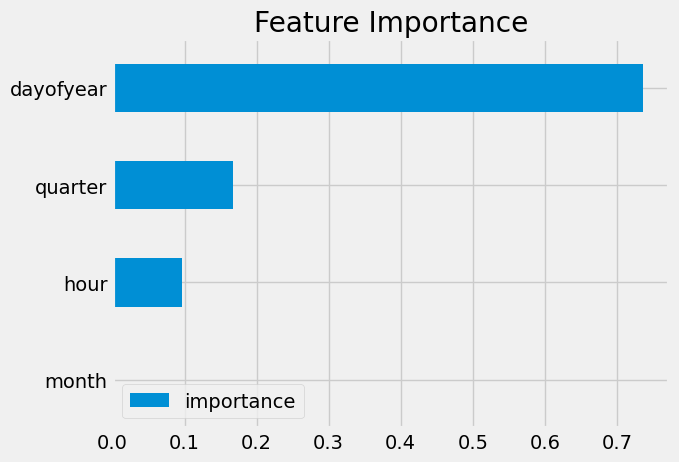

In [63]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

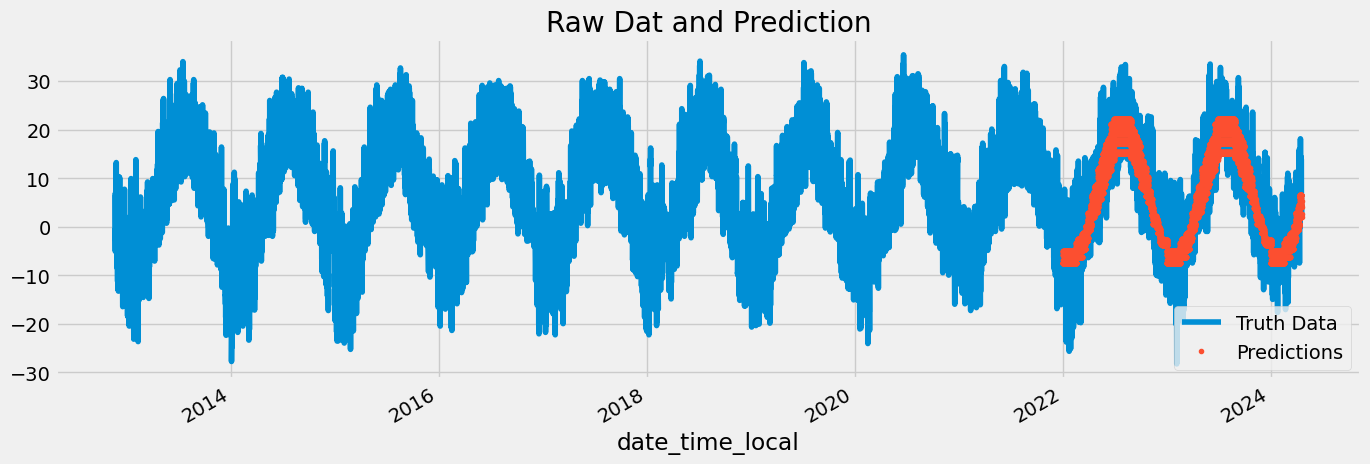

In [64]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['temperature']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

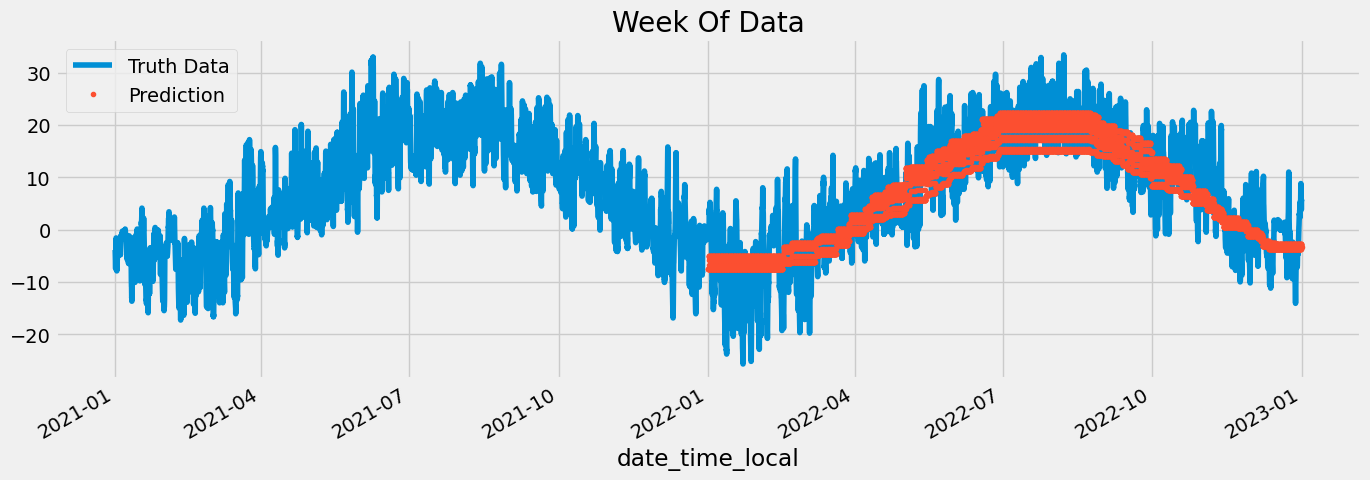

In [65]:
ax = df.loc[(df.index > '01-01-2021') & (df.index < '01-01-2023')]['temperature'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2021') & (df.index < '01-01-2023')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [66]:
score = np.sqrt(mean_squared_error(test['temperature'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 4.97
